In [ ]:
! pip install scikit-commpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 835 kB/s 
  Created wheel for scikit-commpy: filename=scikit_commpy-0.7.0-py3-none-any.whl size=58556 sha256=e93073a9865d7863e2d8d6ee83601736671b50a9449358624dc25dcb4e5b4d8d
  Stored in directory: /root/.cache/pip/wheels/52/2a/a2/2daff6a2d5e3b96d70fb03e5b0699ce70c98cb4c00c8107c38
Successfully built scikit-commpy


In [ ]:
import numpy as np
from scipy.linalg import hadamard
from scipy.stats import ortho_group
import commpy.modulation as modulation
import cmath

In [ ]:
def Hermitian(matrix):
    [raws,columns]=matrix.shape
    conjec= np.zeros((raws,columns), dtype=complex)
    i=0
    while i<columns:
          conjec[:,i]=np.conj(matrix[:,i])
          i+=1
    reversed_conjec=conjec[-1::-1]
    z = np.zeros((1,L)) 
    modulated_uncodeda=np.vstack(z)
    modulated_uncodeda=np.vstack((modulated_uncodeda,matrix))
    modulated_uncodedb=np.vstack((modulated_uncodeda,z))
    Hermitian_Data=np.vstack((modulated_uncodedb,reversed_conjec))
    return Hermitian_Data

def PAPRformatrix(matrix):
    [raws,columns]=matrix.shape
    PAPR = np.zeros(columns)
    PAPRdB = np.zeros(columns)
    s=0
    while s<columns:
            max=np.max(matrix[:,s]*np.conj(matrix[:,s]))
            mean=np.sum(matrix[:,s]*np.transpose(np.conj(matrix[:,s])))/len(matrix[:,s])
            PAPR[s]=max/mean
            PAPRdB[s]=10*np.log10(PAPR[s])
            s+=1
    return [PAPR,PAPRdB]

def PAPRforcolumn(matrix):
    raws=matrix.shape
    PAPR = np.zeros(1)
    PAPRdB = np.zeros(1)
    max=np.max(matrix*np.conj(matrix))
    mean=np.sum(matrix*(np.conj(matrix)))/len(matrix)
    PAPR=max/mean
    PAPRdB=10*np.log10(PAPR) 
    return [PAPR,PAPRdB]

def IFFTformatrix(matrix):
    [raws,columns]=matrix.shape
    Data_ifft = np.zeros((raws,columns), dtype=complex)
    p=0
    while p<columns:
          Data_ifft[:,p]= np.fft.ifft(matrix[:,p])
          p+=1
    return Data_ifft

def matrixP2S(matrix):
    [raws,columns]=matrix.shape
    i = 0
    s = 0
    t = 0
    serial_data = np.zeros((raws*columns), dtype=complex)
    while i < columns:
          k=0
          while k < raws: 
                g=(matrix[k,i])
                serial_data[t]=g
                t+=1
                k+=1
          i+=1    
    return serial_data

def columnP2S(matrix):
    i = 0
    serial_data = np.zeros((len(matrix)), dtype=complex)
    for i in range(len(matrix)):
        serial_data[i]=matrix[i]
    return serial_data

def columnS2P(matrix):
    i = 0
    parallel_data = np.zeros((len(matrix),1), dtype=complex)
    for i in range(len(matrix)):
        parallel_data[i,0]=matrix[i]
    return parallel_data


def CP(matrix,length_of_CP):
    [raws,columns]=matrix.shape
    CP = matrix[raws-length_of_CP:raws,:]
    Data_CP = np.vstack((CP, matrix))
    return Data_CP

def CPpercolumn(matrix,length_of_CP):
    raws=matrix.shape
    CP = matrix[raws-length_of_CP:raws]
    Data_CP = np.vstack((CP, matrix))
    return Data_CP

def matrixneededshape(matrix,raws,columns):
    mat= np.zeros((raws,columns), dtype=complex)
    i=0
    t=0
    while i<columns:
          k=0
          while k<raws:
                g=matrix[t]
                mat[k,i]=g
                t+=1            
                k+=1
          i+=1
    return mat

def complex_ortho_matrix(raws,columns):
    h=np.array([1, -1, 1j, -1j])
    Ortho=np.zeros((raws,columns), dtype=complex)   #initialization
    l=0
    while l<N:
          Ortho[l]=np.random.choice(h,columns)
          l+=1
    return Ortho 

def decimalToBinary(n): 
    return bin(n).replace("0b","") 

def oversampling(matrix,L):
    [raws,columns]=matrix.shape
    oversampling_matrix=np.zeros((raws*(L-1),columns), dtype=complex)
    oversampled_Data1 =np.vstack((matrix[0:int(raws/2),:],oversampling_matrix))
    oversampled_Data=np.vstack((oversampled_Data1,matrix[int((raws/2)):raws,:]))
    return oversampled_Data
    
def calcSecondaryPeaksValue(number_of_subcarriers,number_of_PRTs,number_of_iterations):
    for g in range(number_of_iterations):
        kernel=np.zeros((number_of_subcarriers,1), dtype=complex)   #initialization
        index = np.random.choice(number_of_subcarriers, number_of_PRTs, replace=False) 
        i=0 
        while i<number_of_PRTs:
              kernel[index[i],0]=1
              i=i+1
        time_domain_kernel=IFFTformatrix(kernel)    
        position=np.argmax(np.abs(time_domain_kernel))
        secondarypeaksvalue=0
        for p in range(number_of_subcarriers):
          if p != position:
             secondarypeaksvalue=secondarypeaksvalue+np.abs(time_domain_kernel[p,0])
        if g==0:
          previous_value=secondarypeaksvalue
          best_time_domain_kernel=time_domain_kernel
          best_PRTs_locations=index
        else:
           if secondarypeaksvalue <= previous_value:
             previous_value=secondarypeaksvalue
             best_time_domain_kernel=time_domain_kernel
             best_PRTs_locations=index
    return best_PRTs_locations

def S_SCR_per_iteration(matrix,peak_position):
            matrix_clipped=np.zeros((NN*oversampling_rate), dtype=complex)
            position=peak_position
            max_peak=matrix[position]    
            phase=max_peak/np.abs(max_peak)
            length_of_the_matrix=len(matrix)
            #calculating clipping threshold
            square_mean=np.sum((np.abs(matrix))**2)/length_of_the_matrix
            A=np.sqrt(CR*square_mean)   #clipping threshold
            c_max=(max_peak-(A*phase))*np.roll(Peak_Reduction_Kernel,position)

            #do clipping
            p1=0
            p2=0
            for g in range (length_of_the_matrix):
                  if np.abs(matrix[g])>A:
                    phase=matrix[g]/np.abs(matrix[g])
                    matrix_clipped[g] =A*phase
                    p1=p1+(np.abs(c_max[g])*np.abs(matrix[g]-matrix_clipped[g]))
                    p2=p2+((np.abs(c_max[g]))**2)
                  else: 
                    matrix_clipped[g]=matrix[g]
            clipping_noise=matrix-matrix_clipped
            scaling_factor=p1/p2   #muu
            ebsai[position]=scaling_factor
            value = ebsai*c_max
            return value

def peak_pos(data,L):
  N=data.shape[0]
  max_peaks=np.zeros((L),dtype=complex)
  a_sort1=np.sort(np.abs(data))
  a_sort=a_sort1[::-1] 
  peak_position=np.zeros(L)
  for i in range(L):
     max_peaks[i]=a_sort[i]
  for k in range(L):
   for j in range(N):
     if np.abs(data[j])==max_peaks[k]:
       peak_position[k]=j
  return peak_position

In [ ]:
           ###Start Tone Reservation###

#the selection of the tone location
NN=256   #total number of subcarriers (TR+Data)
TR=32   #assum
N= NN - TR   #data subcarriers
L= 10000 #number of time slots
M = 16   #modulation order (QPSK)
oversampling_rate = 4   #minimum value for over sampling
CR=10**(0.2)
K = int(np.log2(M))   #number of bit per modulation symbol
Target_PAPRdB= 6
kernel0=np.zeros((NN,1), dtype=int)   #initialization
separation_between_ones=int(NN/TR)   #separation_between_ones
positions_of_ones = np.zeros(TR)   #initialization
decimal_numbers_of_constellation = np.zeros(M)   #initialization
binary_numbers_of_constellation = np.zeros((M,K), dtype=complex)   #initialization
Data2=np.zeros((NN,L), dtype=complex)   #initialization
final_PAPRdB = np.zeros(L)   #initialization
Data4 = np.zeros((N), dtype=complex)   #initialization
modulated_uncoded2=np.zeros((N,L), dtype=complex)   #initialization
modulated_uncoded3=np.zeros((NN,L), dtype=complex)   #initialization
Data4_clipped=np.zeros((NN*oversampling_rate), dtype=complex)
ebsai=np.ones((NN*oversampling_rate), dtype=int)

index = np.random.choice(modulated_uncoded3[:,1].shape[0], TR, replace=False) 
print('index',index)

#zero ones vector and ifft
i=0 
j=0 
while i<TR:
      kernel0[index[i],0]=1
      i=i+1
positions_of_ones=index

kernel0=oversampling(kernel0,oversampling_rate)


Peak_Reduction_Kernel=columnP2S((np.sqrt(NN)/TR)*IFFTformatrix(kernel0))
#print("Peak_Reduction_Kernel",Peak_Reduction_Kernel)

#Data generation
Data1 = np.random.randint(2,size=(K*N*L))

#modulation from commpy library
modem = modulation.QAMModem(M)   # M-PSK modem initialization
modulated_uncoded1 = modem.modulate(Data1)

modulated_uncoded2=matrixneededshape(modulated_uncoded1,N,L)

#consist of total modulated data with tones
for i in range(L):
  y=0
  for j in range(NN):
    if j in positions_of_ones:
      #Data2[j,i]=np.random.choice(Data1)
      #Data2[j,i]=0
      Data2[j,i]=np.random.choice(modulated_uncoded2[:,i])
    else:
      Data2[j,i]=modulated_uncoded2[y,i]
      y+=1
#print("Data2",Data2)
fff=Data2
Data2=oversampling(Data2,oversampling_rate)

index [166  58 135  48 169  85 232  30 198 124 253 112  59  42 160 246  83 158
 176  89 182 117 249 122  53  68  22 255 156 153   0  14]


In [ ]:
   ###S_SCR Algorithm###
iteration = 18
j= 0    #for every time slot
while j<L:
      value=0
      k=0
      Data3=np.fft.ifft(Data2[:,j])
      Data4=columnP2S(Data3)
      #print("Data3",Data3)
      while k<iteration:
            #peak detection to find value and phase of max peak at data (x+c) in time domain every iteration
            position=np.argmax(np.abs(Data4))
            max_peak=Data4[position]    
            phase=max_peak/np.abs(max_peak)

            #calculating clipping threshold
            segma=0
            for p in range(NN*oversampling_rate):
              segma=segma+(np.abs(Data4[p]))**2
            
            A=CR*np.sqrt((1/(NN*oversampling_rate))*segma)   #clipping threshold
            c_max=(max_peak-(A*phase))*np.roll(Peak_Reduction_Kernel,position)

            #do clipping
            p1=0
            p2=0
            for g in range (NN*oversampling_rate):
                  if np.abs(Data4[g])>A:
                    phase=Data4[g]/np.abs(Data4[g])
                    Data4_clipped[g] =A*phase
                    p1=p1+(np.abs(c_max[g])*np.abs(Data4[g]-Data4_clipped[g]))
                    p2=p2+((np.abs(c_max[g]))**2)
                  else: 
                    Data4_clipped[g]=Data4[g]
            clipping_noise=Data4-Data4_clipped
            scaling_factor=p1/p2   #muu
            ebsai[position]=scaling_factor
            
            value = ebsai*c_max
            Data4 = Data4 - value

            #PAPR calculation
            Data5=columnS2P(Data4)   #we will calculate PAPR for this column(Data5) 
            [PAPR,PAPRdB]=PAPRformatrix(Data5)   #to calculate PAPR every iteration
            k+=1
      final_PAPRdB[j]=PAPRdB
      j+=1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5, 1.0, 'TR PAPR simulation')

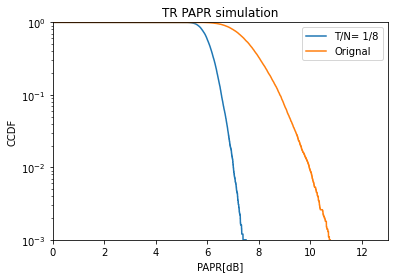

In [ ]:
#CCDF drawing 
import matplotlib.pyplot as plt
count, bins_count = np.histogram(final_PAPRdB,bins=1000000,range=(0,15))
cdf = np.cumsum(count)/L
#plt.plot(bins_count[1:], cdf, label="CDF")   #draw CDF
plt.plot(bins_count[1:], (1-cdf), label='T/N= 1/'+str(int(NN/TR)))   #draw CCDF
plt.legend()

              #####PAPR for Data without SLM reduction technique#####
data_final2 = IFFTformatrix(modulated_uncoded2)   #IFFT
[PAPR,PAPRdB]=PAPRformatrix(data_final2)   #PAPR
#print(PAPRdB)

#CCDF drawing
import matplotlib.pyplot as plt
count, bins_count = np.histogram(PAPRdB,bins=1000000,range=(0,15))
cdf = np.cumsum(count)/L
#plt.plot(bins_count[:], cdf, label="CDF")
plt.plot(bins_count[1:], (1-cdf), label="Orignal")
plt.legend()
plt.yscale('log')
plt.ylim(10**-3,10**0)
plt.xlim(0,13)
plt.xlabel('PAPR[dB]')
plt.ylabel('CCDF')
plt.title('TR PAPR simulation')